In [1]:
import os
from glob import glob
from pathlib import Path

import imageio
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
example_vh = "data/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-9_y-27_vh.png"
example_vv = "data/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-9_y-27_vv.png"
example_flood_msk = "data/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-9_y-27.png"
example_water_msk = "data/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-9_y-27.png"

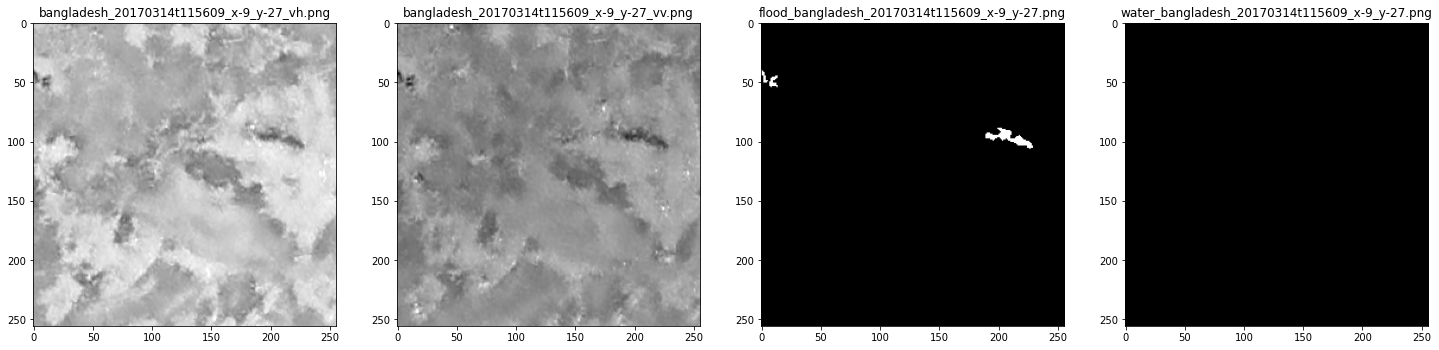

In [3]:
plt.figure(figsize=(25,10)) # specifying the overall grid size

for i, img in enumerate([example_vh, example_vv, example_flood_msk, example_water_msk]):
    plt_title = img.split("/")[-1]
    if "flood" in img:
        plt_title = f"flood_{plt_title}"
    elif "water" in img:
        plt_title = f"water_{plt_title}"
        
    plt.subplot(1,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(mpimg.imread(img))
    plt.title(plt_title)

plt.show()

In [5]:
img_vh = Image.open(example_vh)
img_flood = Image.open(example_flood_msk)
img_water = Image.open(example_water_msk)

In [6]:
(img_vh.size, img_vh.mode, img_vh.info), (img_flood.size, img_flood.mode, img_flood.info)

(((256, 256), 'RGB', {}), ((256, 256), 'RGB', {}))

In [7]:
img_vh_np = np.array(img_vh)
img_fld_np = np.array(img_flood)
img_wtr_np = np.array(img_water)

In [8]:
img_vh_np.shape, img_fld_np.shape, img_wtr_np.shape

((256, 256, 3), (256, 256, 3), (256, 256, 3))

In [9]:
np.unique(img_fld_np), np.unique(img_wtr_np)

(array([  0, 255], dtype=uint8), array([0], dtype=uint8))

## fix files names

In [13]:
# images_vv = sorted([str(i) for i in list(Path("data/train/").rglob("**/vv/*.png"))])
# images_vh = sorted([str(i) for i in list(Path("data/train/").rglob("**/vh/*.png"))])
# images_fld = sorted([str(i) for i in list(Path("data/train/").rglob("**/flood_label/*.png"))])
# images_wtr = sorted([str(i) for i in list(Path("data/train/").rglob("**/water_body_label/*.png"))])

In [14]:
# all_files = []
# for f in images_vv:
#     png_name = f.split("/")[-1]
#     fname = png_name[:-7]
#     base = "/".join(f.split("/")[:-1])
    
#     if any(fname in s for s in images_vh) and any(fname in s for s in images_fld) and any(fname in s for s in images_wtr):
#         vh_idx = [i for i, x in enumerate(images_vh) if fname in x][0]
#         fld_idx = [i for i, x in enumerate(images_fld) if fname in x][0]
#         wtr_idx = [i for i, x in enumerate(images_wtr) if fname in x][0]
        
#         all_files.append((f, images_vh[vh_idx], images_fld[fld_idx], images_wtr[wtr_idx]))
    
#     else:
#         print(f"{f}: not found in all folders")

In [15]:
# all_files[:2]

In [16]:
# any("bangladesh_20170314t115609_x-0_y-0_vh.png" in s for s in images_vh)
# images_vh[[i for i, x in enumerate(images_vh) if "bangladesh_20170314t115609_x-0_y-0" in x][0]]

In [17]:
# df = pd.DataFrame(all_files, columns=["vv", "vh", "flood_label", "water_body_label"])

In [18]:
# df.to_csv("all_files_harmonized.csv")

## input data pipeline

- following is a simple implementation that only takes `vv` images and `flooding` masks for UNet

In [19]:
base_path = "data/train"
csv_file = "all_files_harmonized.csv"

In [20]:
def collect_image_paths_old(base_path, img_type):
    files = []
    for i in list(Path(base_path).rglob(f"**/{img_type}/*.png")):
        files.append(str(i.name))
            
    return [os.path.join(base_path, i) for i in sorted(files)]

In [56]:
def collect_image_paths(csv, img_type):
    df = pd.read_csv(csv, index_col=0)
    assert img_type in list(df.columns)
    
    return df[img_type].tolist()

In [22]:
images_vv = collect_image_paths(csv_file, img_type="vv")
images_fld = collect_image_paths(csv_file, img_type="flood_label")

In [23]:
images_vv[123], images_fld[123]

('data/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-11_y-41_vv.png',
 'data/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-11_y-41.png')

In [24]:
# train test split
train_x, test_x = train_test_split(images_vv, test_size=0.2, random_state=112)
train_y, test_y = train_test_split(images_fld, test_size=0.2, random_state=112)

In [25]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    img = tf.identity(img, name=path.decode().split("/")[-1])

    return img

In [26]:
def load_flood_mask(path):
    # https://www.spacefish.biz/2020/11/rgb-segmentation-masks-to-classes-in-tensorflow/
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask)
    
    colors = [
      (0, 0, 0), # black - none flood
      (255, 255, 255) # white - flood
    ]

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(mask, color), axis=-1)
        one_hot_map.append(class_map)

    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)

    mask = tf.argmax(one_hot_map, axis=-1)
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.cast(mask, tf.float32, name=path.decode().split("/")[-1])
    
    return mask

In [27]:
def preprocess(img_path, mask_path):
    
    def f(img_path, mask_path):
        x = load_image(img_path)
        y = load_flood_mask(mask_path)
        print(img_path, mask_path)
        
        return x, y
    
    image, mask = tf.numpy_function(f, [img_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    
    return image, mask

In [28]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size=batch)
    dataset = dataset.prefetch(2)
    
    return dataset

In [33]:
train_ds = tf_dataset(train_x, train_y, batch=1)
test_ds = tf_dataset(test_x, test_y, batch=1)

b'data/train/nebraska_20170108t002112/tiles/vv/nebraska_20170108t002112_x-11_y-17_vv.png' b'data/train/nebraska_20170108t002112/tiles/flood_label/nebraska_20170108t002112_x-11_y-17.png'
b'data/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-7_y-30_vv.png' b'data/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-7_y-30.png'
b'data/train/nebraska_20170402t002111/tiles/vv/nebraska_20170402t002111_x-23_y-9_vv.png' b'data/train/nebraska_20170402t002111/tiles/flood_label/nebraska_20170402t002111_x-23_y-9.png'
b'data/train/northal_20191004t234700/tiles/vv/northal_20191004t234700_x-20_y-34_vv.png' b'data/train/northal_20191004t234700/tiles/flood_label/northal_20191004t234700_x-20_y-34.png'
b'data/train/nebraska_20170731t002118/tiles/vv/nebraska_20170731t002118_x-21_y-8_vv.png' b'data/train/nebraska_20170731t002118/tiles/flood_label/nebraska_20170731t002118_x-21_y-8.png'


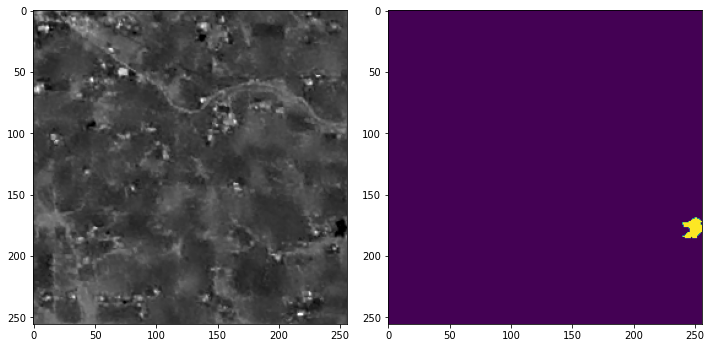

In [55]:
for i, j in test_ds.take(1):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(i[0].numpy())
    axes[1].imshow(j[0].numpy())
    fig.tight_layout()